# IMPORT THE LIBRARIES AND READ THE DATASET

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as pyo
import seaborn as sns
import pandas as pd
import networkx as nx
from networkx.algorithms import community
import community as community_louvain
from itertools import chain
from operator import itemgetter

In [56]:
dataset = pd.read_csv("bitcoin.csv", header=None, names=['Source', 'Target', 'Rating', 'Time'])
dataset['Time'] = pd.to_datetime(dataset['Time'], unit='s')

In [57]:
dataset.head()

,Source,Target,Rating,Time
0,6,2,4,2010-11-08 18:45:11.728359936
1,6,5,2,2010-11-08 18:45:41.533780224
2,1,15,1,2010-11-08 19:05:40.390490112
3,4,3,7,2010-11-08 19:41:17.369750016
4,13,16,8,2010-11-08 22:10:54.447459840


# VISUALIZE THE IN-DEGREE AND OUT-DEGREE DISTRIBUTIONS OF THE BITCOIN BLOCKCHAIN

5881
35592
Each node has on average 6.052031967352491 incoming connections and 6.052031967352491 outgoing connections


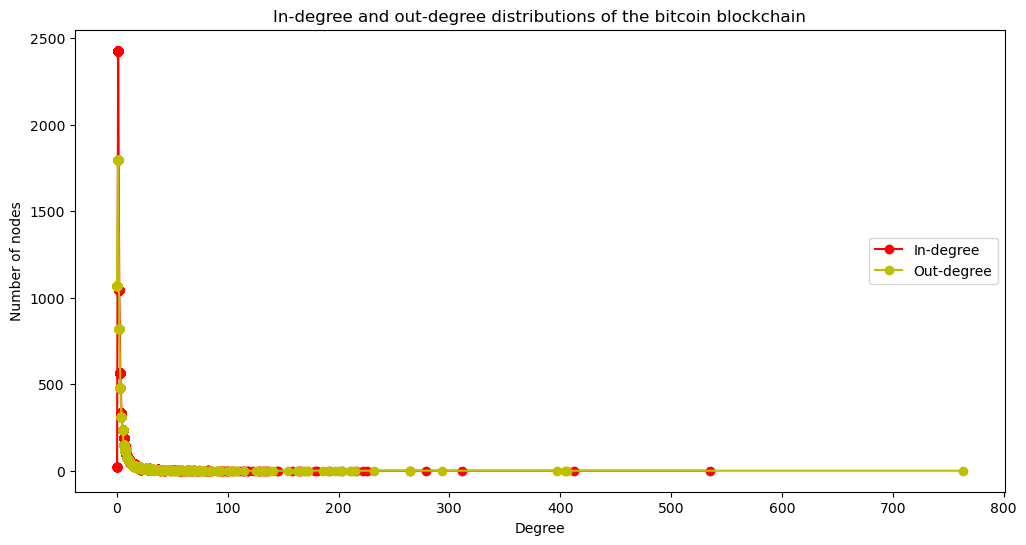

In [58]:
bitcoin_blockchain = nx.from_pandas_edgelist(dataset, source = "Source", target = "Target",
                                            edge_attr = "Rating", 
                                            create_using = nx.DiGraph())
# We represent the bitcoin blockchain as a directed graph. The edge starts from the rater and ends in the ratee.
# The weight of each edge is represented by the rating issued by the rater.
nx.is_directed(bitcoin_blockchain)
# How many nodes and how many edges are there in the graph?
print(bitcoin_blockchain.number_of_nodes())
print(bitcoin_blockchain.number_of_edges())
# The network consists of 5881 and 35592 edges.
# In an undirected graph there is no need to distinguish between in-degree and out-degree as each node is both 
# source and destination of a connection and the degree of a vertex is defined as the number of connections the vertex
# has. In a directed graph, we need to distinguish between in-degree (incoming connections) and out-degree (outgoing
# connections).
# G.in_degree() is a list that stores tuples of the form (node, in_degree)
# With the following code i compute the average in-degree and average out-degree to see how many incoming and
# outgoing connection a node has on average.
in_degrees = [degree for node, degree in bitcoin_blockchain.in_degree()] # list that stores in-degrees of each node.
out_degrees = [degree for node, degree in bitcoin_blockchain.out_degree()] # list that stores out-degrees of each node.
n_nodes = bitcoin_blockchain.number_of_nodes()
avg_in_degree = sum(in_degrees)/n_nodes
avg_out_degree = sum(out_degrees)/n_nodes
print(f"Each node has on average {avg_in_degree} incoming connections and {avg_out_degree} outgoing connections")
# Each node has on average the same number of incoming and outgoing edges. It might be more useful to visualize
# the degree distribution of the nodes (we plot the degree on the x-axis and the number of nodes for each degree
# on the y-axis. Of course we will use a different color for the in-degree and the out-degree).
incoming = sorted(in_degrees)
outgoing = sorted(out_degrees)
y_incoming = [in_degrees.count(x) for x in incoming] # we store the number of occurrences for each value in the 
# list containing sorted in-degrees.
y_outgoing = [out_degrees.count(x) for x in outgoing] # we do the same for sorted out-degrees.
# plot in-degree and out-degree distributions.
plt.figure(figsize=(12,6))
plt.title("In-degree and out-degree distributions of the bitcoin blockchain")
plt.xlabel("Degree")
plt.ylabel("Number of nodes")
plt.plot(incoming, y_incoming, "ro-") # plot for the in-degree
plt.plot(outgoing, y_outgoing, "yo-") # plot for the out-degree
plt.legend(["In-degree", "Out-degree"], loc = "center right", frameon = True) # legend

# BASIC ANALYSIS

In [59]:
nx.info(bitcoin_blockchain)

'DiGraph with 5881 nodes and 35592 edges'

- a directed graph is (weakly) connected if its underlying undirected graph which is obtained by replacing directed edges with undirected edges is connected.
- a directed graph is (strongly) connected if for every pair of vertices (u,v) there is a directed path from u to v and from v to u.

In [60]:
# check connection
print(nx.is_weakly_connected(bitcoin_blockchain))
print(nx.is_strongly_connected(bitcoin_blockchain))

False
False


In [61]:
# number of weakly connected components.
nx.number_weakly_connected_components(bitcoin_blockchain)

4

In [62]:
# save the length of weakly connected components (in descending order) in a list.
length_wcc = [len(c) for c in sorted(nx.weakly_connected_components(bitcoin_blockchain), key=len, reverse = True)]

In [63]:
length_wcc # we see that there is a weakly connected component of size 5875 and three weakly connected 
# components of size 2.

[5875, 2, 2, 2]

In [64]:
# number of strongly connected components.
nx.number_strongly_connected_components(bitcoin_blockchain)

1144

In [65]:
# save the length of strongly connected components (in descending order) in a list.
length_scc = [len(c) for c in sorted(nx.strongly_connected_components(bitcoin_blockchain), key=len, reverse = True)]
# if we print the list, we can see that there is a strongly connected component of size 4709 (giant component). 
# All the other strongly connected components have size 1-2.

# CREATE TWO SEPARATE NETWORKS (ONE FOR POSITIVE RATINGS AND ONE FOR NEGATIVE RATINGS) IN ORDER TO IMPROVE READABILITY

- Here we create a new dataframe containing only positive ratings. We group by target so that each target will appear only once and we generate two columns which contain lists that store the positive ratings that the target has received and the sources of such ratings.

In [66]:
positive_ratings = dataset[dataset['Rating'] > 0].groupby('Target').apply(lambda x: {'positive_ratings': x['Rating'].tolist(), 'sources': x['Source'].tolist()}).apply(pd.Series).reset_index()

In [67]:
positive_ratings.head()

,Target,positive_ratings,sources
0,1,"[8, 8, 3, 8, 1, 1, 3, 1, 9, 3, 2, 1, 2, 8, 1, ...","[21, 10, 5, 13, 32, 34, 31, 35, 17, 8, 47, 54,..."
1,2,"[4, 5, 7, 2, 8, 2, 2, 1, 1, 1, 1, 1, 1, 8, 5, ...","[6, 21, 10, 61, 1, 54, 132, 142, 146, 110, 149..."
2,3,"[7, 7, 5, 7, 6, 8, 1, 5, 1, 3, 6, 1]","[4, 21, 17, 10, 7, 2, 64, 217, 269, 397, 1, 439]"
3,4,"[1, 2, 5, 2, 3, 2, 2, 1, 1, 1, 4, 2, 4, 1, 7, ...","[26, 6, 2, 31, 61, 66, 57, 41, 87, 39, 72, 282..."
4,5,"[2, 1, 4]","[6, 7, 1]"


In [68]:
dataset_pos = dataset.loc[dataset["Rating"] > 0]

In [69]:
dataset_pos_grouped = dataset_pos.groupby("Target")["Rating"].count().to_frame("number of ratings") # we want to 
# store the number of positive ratings that each target has received.

In [70]:
dataset_pos_grouped.describe() # 75% of targets have received less than 4 reviews. We try to keep only targets
# which have received more than 4 reviews in order to reduce the number of nodes and improve the visualization.

,number of ratings
count,5497.000000
mean,5.826633
std,17.368867
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,535.000000


In [71]:
# Create an empty directed graph.
G_pos = nx.DiGraph()

# we iterate over target, list of positive ratings, list of sources that issued the ratings
for target, rating_list, source_list in positive_ratings.itertuples(index=False):
    if rating_list and source_list:
            weight = sum(rating_list)/len(rating_list) # compute the average rating
            if len(rating_list) > 4 and weight > 3: # if the target has received more than 4 reviews and the average
                # rating is greater than 3 then add the node and the edge between source and target with weight
                # equal to the average rating of the target.
                G_pos.add_node(target)
                source = source_list[0] # to simplify we assume that the rating is issued by the first node in the list of
            # sources
                G_pos.add_edge(source, target, weight=weight)

In [72]:
G_pos.number_of_nodes()

175

In [73]:
G_pos.number_of_edges()

104

In [74]:
in_degree = dict(G_pos.in_degree(weight = "weight"))

In [75]:
in_degree_sorted = dict(sorted(in_degree.items(), key=lambda item: item[1], reverse = True)) # sort the dictionary
# by value of the in_degree

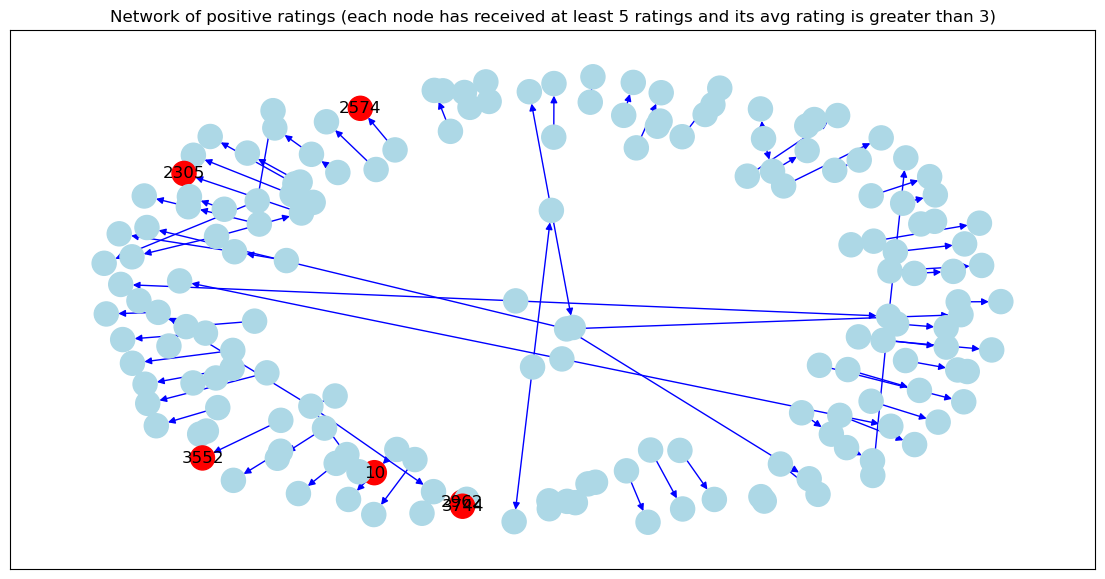

In [77]:
fig, ax = plt.subplots(figsize = (14, 7))
ax.set_title("Network of positive ratings (each node has received at least 5 ratings and its avg rating is greater than 3)")
pos = nx.spring_layout(G_pos) # spring layout
# plot the edges with a different thickness depending on the edge weight
# weights = [G_pos[source][target]["weight"] for source, target in G_pos.edges]
labels = {} # we want to plot labels only for nodes with very positive rating (>= 6)
for node in G_pos.nodes:
    if in_degree_sorted[node] >= 6:
        labels[node] = node
    else:
        labels[node] = ""
colors = [] # we want to use a different color for very positive nodes.
for key, value in labels.items():
    if labels[key] == "": # if the label of the node is equal to "" means if the average rating of the node is below 6
        colors.append("lightblue")
    else:
        colors.append("red") # if the average rating of the node is >= 6, make it red
nx.draw_networkx(G_pos, pos = pos, with_labels = True, node_color = colors, node_size = 300, 
                 edge_color = "blue", labels = labels, ax = ax)

Nodes 10, 2962, 2574, 3744, 2305, 3552 have the highest average positive rating in the network.

# WE PROCEED IN THE SAME WAY FOR NEGATIVE RATINGS 

In [78]:
negative_ratings = dataset[dataset['Rating'] < 0].groupby('Target').apply(lambda x: {'negative_ratings': x['Rating'].tolist(), 'sources': x['Source'].tolist()}).apply(pd.Series).reset_index()

In [79]:
negative_ratings.head()

,Target,negative_ratings,sources
0,2,[-2],[3722]
1,3,"[-2, -1, -10, -10, -7, -10, -10, -3, -10]","[1220, 3445, 361, 2388, 3452, 1018, 115, 5955,..."
2,6,"[-5, -1, -1, -10, -2, -1, -10, -10]","[425, 13, 2067, 1318, 4385, 3988, 1352, 96]"
3,13,[-10],[1352]
4,20,"[-5, -1]","[2266, 2877]"


In [80]:
dataset_neg = dataset.loc[dataset["Rating"] < 0]

In [81]:
dataset_neg_grouped = dataset_neg.groupby("Target")["Rating"].count().to_frame("number of negative ratings")

In [82]:
dataset_neg_grouped.describe() # 75% of targets have received less than 3 reviews. We try to keep only targets
# which have received more than 3 reviews in order to reduce the number of nodes and improve the visualization.

,number of negative ratings
count,1254.000000
mean,2.841308
std,4.730690
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,75.000000


In [83]:
# create an empty directed 
G_neg = nx.DiGraph()

# we iterate over target, list of negative ratings, list of sources that issued the ratings
for target, rating_list, source_list in negative_ratings.itertuples(index=False):
    if rating_list and source_list:
        weight = sum(rating_list)/len(rating_list) # compute the average rating
        if len(rating_list) > 3 and weight < -8: # add the node only if the target has received at least 4 negative reviews. We do not
            # want to plot targets with negative ratings but few reviews. We want a strong support for the average negative
            # rating.
            G_neg.add_node(target)
            source = source_list[0] # for simplicity assume that the rating has been issued by the first node in the
            # list of sources
            G_neg.add_edge(source, target, weight=weight)

In [84]:
G_neg.number_of_nodes()

170

In [85]:
G_neg.number_of_edges()

125

In [86]:
neg_in_degree = dict(G_neg.in_degree(weight = "weight"))

In [87]:
neg_in_degree_sorted = dict(sorted(neg_in_degree.items(), key=lambda item: item[1], reverse = False))

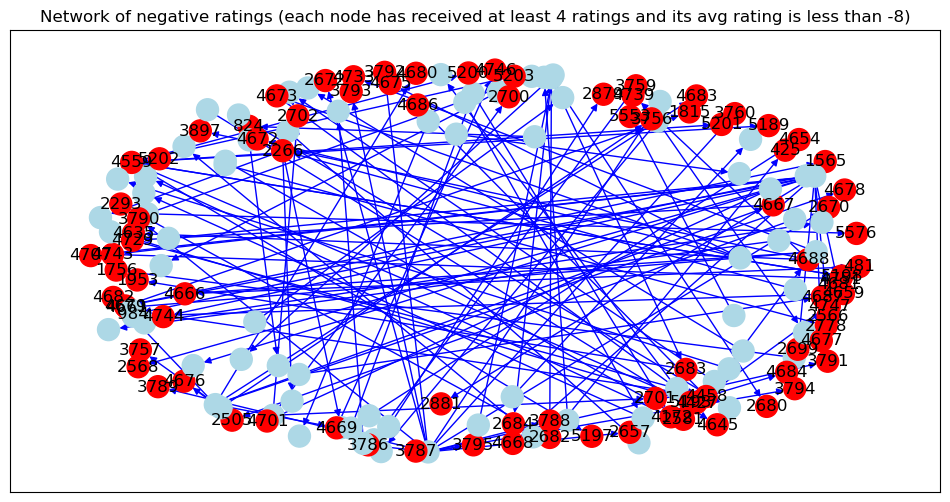

In [88]:
fig, ax = plt.subplots(figsize = (12, 6))
ax.set_title("Network of negative ratings (each node has received at least 4 ratings and its avg rating is less than -8)")
pos = nx.spring_layout(G_neg) # spring layout
# weights = [G_neg[source][target]["weight"] for source, target in G_neg.edges]
labels = {} # we want to plot labels only for nodes with extremely negative ratings (= -10)
for node in G_neg.nodes:
    if neg_in_degree_sorted[node] == -10:
        labels[node] = node
    else:
        labels[node] = ""
colors = [] # we want to use a different color for extremely negative nodes.
for key, value in labels.items():
    if labels[key] == "": # if the label of the node is equal to "" means if the average rating of the node is != -10
        colors.append("lightblue")
    else:
        colors.append("red") # if the average rating of the node is = -10, make it red
nx.draw_networkx(G_neg, pos = pos, with_labels = True, node_color = colors, node_size = 250, 
                 edge_color = "blue", labels = labels, ax = ax)

# MERGE THE TWO GRAPHS INTO A SINGLE GRAPH

In [89]:
G3 = nx.DiGraph()

G3.add_nodes_from(G_pos.nodes()) # targets that have received more than 4 positive reviews and have average rating greater 
# than 3
G3.add_nodes_from(G_neg.nodes()) # targets that have received more than 3 negative reviews and have average rating smaller
# than -8

G3.add_edges_from(G_pos.edges(data = True))
G3.add_edges_from(G_neg.edges(data = True))

In [90]:
pos_and_neg_in_degree = dict(G3.in_degree(weight = "weight"))

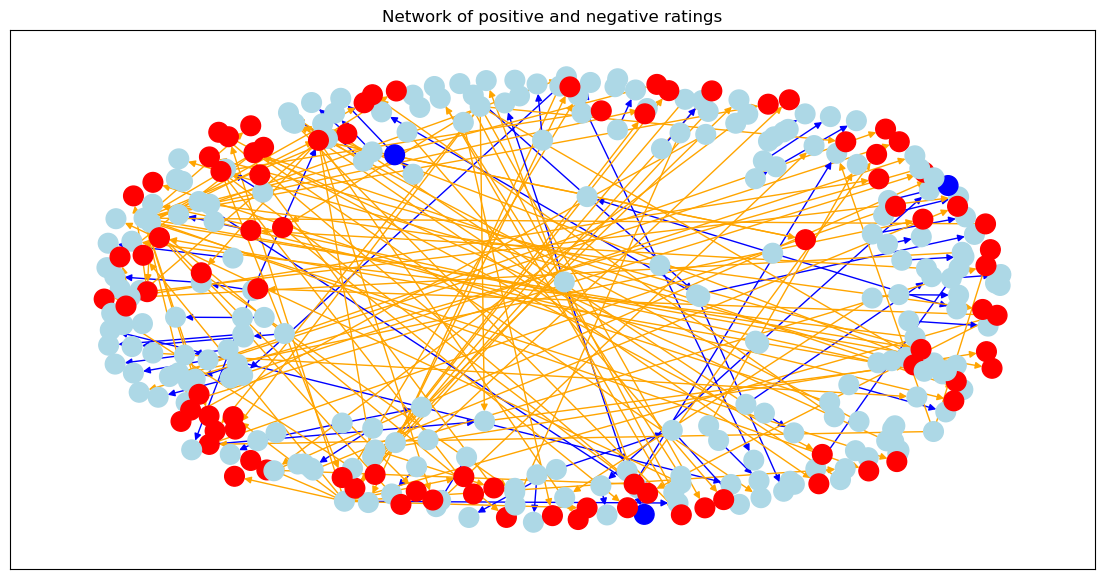

In [91]:
fig, ax = plt.subplots(figsize = (14, 7))
ax.set_title("Network of positive and negative ratings")
pos = nx.spring_layout(G3) # spring layout
# weights = [G_neg[source][target]["weight"] for source, target in G_neg.edges]
#labels = {} # we want to plot labels only for nodes with extremely negative ratings and positive ratings
#for node in G3.nodes:
   # if pos_and_neg_in_degree[node] == -10 or pos_and_neg_in_degree[node] >= 6:
      #  labels[node] = node
    #else:
       # labels[node] = ""
colors = [] # we want to use a different color for extremely negative and positive nodes.
for node in G3.nodes:
    # if the average rating of the node is = -10, make it red
    if pos_and_neg_in_degree[node] == -10:
        colors.append("red")
    elif pos_and_neg_in_degree[node] >= 6: # if the average rating of the node is >= 6, make it blue
        colors.append("blue")
    else:
        colors.append("lightblue") # else make it lightblue
# use a different color for positive and negative edges
edge_colors = []
for edge in G3.edges(data = True):
    if edge[2]["weight"] < 0:
        edge_colors.append("orange")
    else:
        edge_colors.append("blue")
nx.draw_networkx(G3, pos = pos, with_labels = False, node_color = colors, edge_color = edge_colors,
                 node_size = 200, ax = ax)
# in the following graph a node has red color if its average rating is -10, it has blue color if the average rating
# is >= 6, lightblue otherwise. We use the orange color to represent negative edges (edges with weight <0) and the blue
# color to represent positive edges (edges with weight >= 0).